In [1]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as rnd
import time
import GPflow
import tensorflow as tf

In [2]:
M = 20

# Create a dataset and initialise model

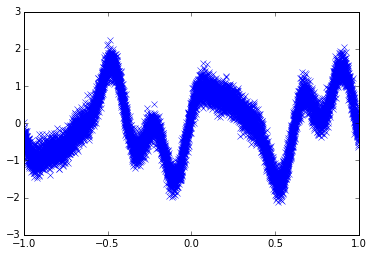

In [3]:
def func(x):
    return np.sin(x * 3*3.14) + 0.3*np.cos(x * 9*3.14) + 0.5 * np.sin(x * 7*3.14)
X = rnd.rand(10000, 1) * 2 - 1
Y = func(X) + rnd.randn(10000, 1) * 0.2
plt.plot(X, Y, 'x')
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 100)[:, None]
Yt = func(Xt)

In [4]:
def init():
    kern = GPflow.kernels.RBF(D, 1)
    Z = X[:M, :]
    m = GPflow.svgp.SVGP(X, Y, kern, GPflow.likelihoods.Gaussian(), Z)
    m.likelihood.variance = 0.1
    return m
m = init()

In [5]:
m._compile()
ground_truth = m._objective(m.get_free_state())[0]
print m.minibatch
print ground_truth

compiling tensorflow function...
done
10000
83066.7758549


# Stochastically calculate bound and show noise
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [6]:
m.minibatch = 100
m._compile()
evals = [m._objective(m.get_free_state())[0] for _ in xrange(100)]

compiling tensorflow function...
done


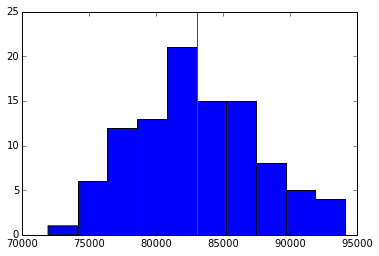

In [7]:
plt.hist(evals)
plt.axvline(np.mean(evals), color='b')
plt.axvline(ground_truth, color='r')

# Show that minibatches speed up computation
The use of using minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is cheaper. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [8]:
mbps = np.logspace(-2, 0, 10)
times = []
for mbp in mbps:
    m.minibatch = int(len(X) * mbp)
    start_time = time.time()
    objs = [m._objective(m.get_free_state())[0] for _ in xrange(20)]
#    plt.hist(objs, bins = 100)
#    plt.axvline(ground_truth, color='r')
    times.append(time.time() - start_time)

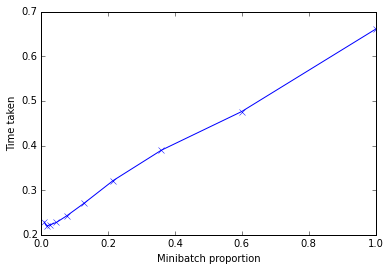

In [9]:
plt.plot(mbps, times, 'x-')
plt.xlabel("Minibatch proportion")
plt.ylabel("Time taken")

# Show working optimisation
This is work in progress...

In [10]:
class DAdamOptimizer(tf.train.AdamOptimizer):
      def _valid_dtypes(self):
            return set([tf.float32, tf.float64])

class DGradientDescentOptimizer(tf.train.GradientDescentOptimizer):
      def _valid_dtypes(self):
            return set([tf.float32, tf.float64])

In [19]:
class opthist(object):
    def __init__(self, m, gap=10):
        self.m = m
        self.i = 0
        self.start_time = time.time()
        self.ilist = []
        self.flist = []
        self.tlist = []
        self.sflist = []
        self.gap = gap
        
    def iteration(self, x):
        if self.i % self.gap == 1:
            mb = self.m.minibatch
            self.m.minibatch = None
            f = self.m._objective(x)[0]
            self.m.minibatch = mb
            self.sflist.append(self.m._objective(x)[0])
            self.flist.append(f)
            self.ilist.append(self.i)
            self.tlist.append(time.time() - self.start_time)
            sys.stdout.write('\r' + str((self.i, f)))
            sys.stdout.flush()
        self.i += 1

In [20]:
m = init()
h = opthist(m, gap=10)

compiling tensorflow function...
done
(101, 11622.906734726384)optimization terminated, setting model state


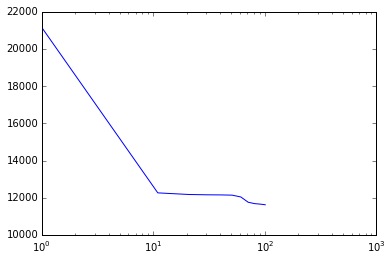

In [17]:
m.optimize(callback=h.iteration, max_iters=102)
plt.plot(h.ilist, h.flist)
plt.xscale('log')

compiling tensorflow function...
done
(991, 12191.218567711279)12177.1258083


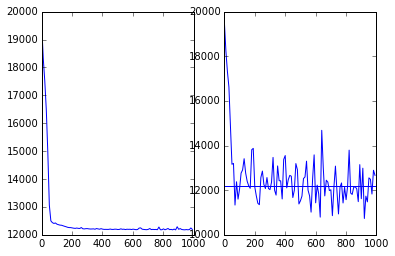

In [23]:
m = init()
m.minibatch = 100
h = opthist(m, gap=10)
m.optimize(callback=h.iteration, method=DGradientDescentOptimizer(tf.constant(0.0001, tf.float64)), max_iters=1000)
plt.subplot(121); plt.plot(h.ilist, h.flist)
plt.subplot(122); plt.plot(h.ilist, h.sflist)
m.minibatch = None
plt.axhline(m._objective(m.get_free_state())[0])
print m._objective(m.get_free_state())[0]

In [16]:
m = init()

In [18]:
print m.likelihood

likelihood.variance transform:+ve prior:None
[ 1.]


In [ ]:
opt_list = [{"method": "L-BFGS-B", "minibatch": len(X)},
            {"method": tf.train.AdamOptimizer(), "cast": True, "minibatch": 1000},
            {"method": tf.train.GradientDescentOptimizer(), "cast": True, "minibatch": 1000}]
for opt in opt_list[1:2]:
    m = init()
    m._compile()
    print m._objective(m.get_free_state())[0]
    if "minibatch" in opt:
        m.minibatch = opt['minibatch']
    m._needs_recompile = True
    ilist = []
    tlist = []
    flist = []
    start_time = time.time()
    def cb(x):
        if cb.iteration % 10 == 0:
            f = m._objective(x)[0]
            flist.append(f)
            ilist.append(cb.iteration)
            tlist.append(time.time() - start_time)
            sys.stdout.write('\r' + str((cb.iteration, f)))
            sys.stdout.flush()
        cb.iteration += 1
    cb.iteration = 0
    m.optimize(max_iters=int(1000 * float(len(X)) / m.minibatch), callback=cb, **opt)
    plt.figure(1)
    plt.subplot(121)
    plt.plot(ilist, flist)
    plt.subplot(122)
    plt.plot(tlist, flist)

# m.optimize(method=DGradientDescentOptimizer(tf.constant(0.0001, tf.float64)), max_iters=10, callback=cb)
# m.optimize(method=tf.train.GradientDescentOptimizer(0.0001), max_iters=10, callback=cb, cast=True)
# m.optimize(method=tf.train.AdamOptimizer(), max_iters=10, callback=cb, cast=True)
# m.optimize(method=DAdamOptimizer(), max_iters=10, callback=cb, cast=False)

In [ ]:
print m._objective(m.get_free_state())[0]
x = m.get_free_state()
x[:5] = 0.0
print m._objective(x)[0]

In [ ]:
x

In [ ]:
ilist